In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt


class Voltmeter:
    def __init__(self, avg, covarience):
        self.mu = avg
        self.sigma = math.sqrt(covarience)
    
    def read(self, N=1):
        return np.random.normal(self.mu, self.sigma, N)

v = Voltmeter(14.4, 4) # avg 14.4, covarience = 4


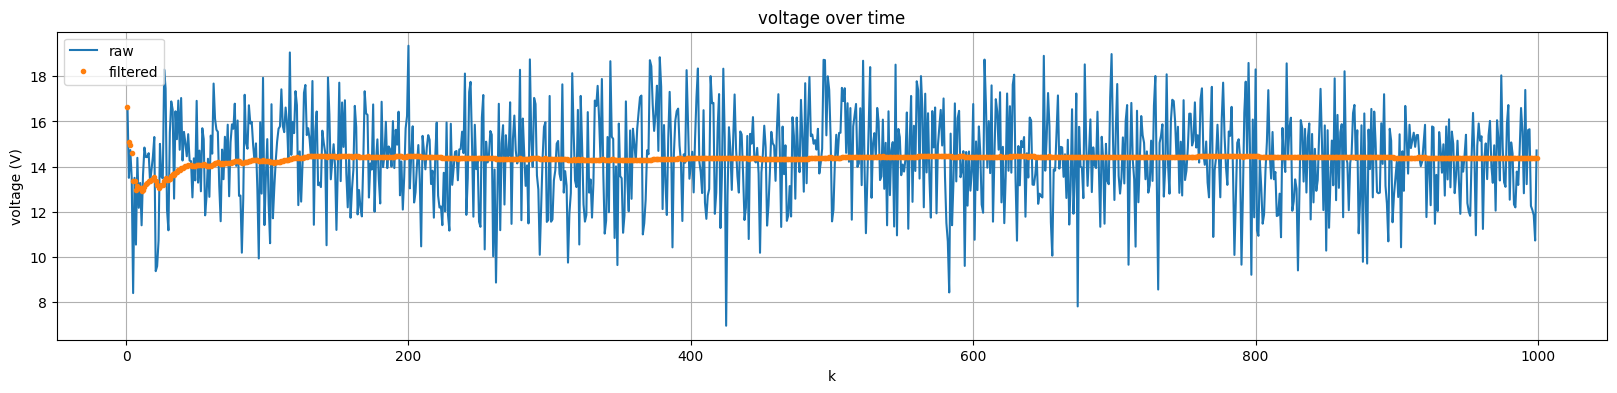

In [18]:
x_bar_k = 0
readings = []
result = []
for k in range(1, 1000):
    x_k = v.read(1)[0]
    readings.append(x_k)
    new_x_bar_k = ((k-1)/k) * x_bar_k + (1/k) * x_k
    result.append(new_x_bar_k)
    x_bar_k = new_x_bar_k

fig, ax = plt.subplots(figsize=(20, 4), dpi=100)  # 2000x400 px
ax.plot(range(1,1000), readings, marker='', ls='-', color='C0', label='raw')
ax.plot(range(1,1000), result, marker='.', ls='', color='C1', label='filtered')
ax.set(xlabel='k', ylabel='voltage (V)', title='voltage over time')
ax.grid()
ax.legend()
plt.show()

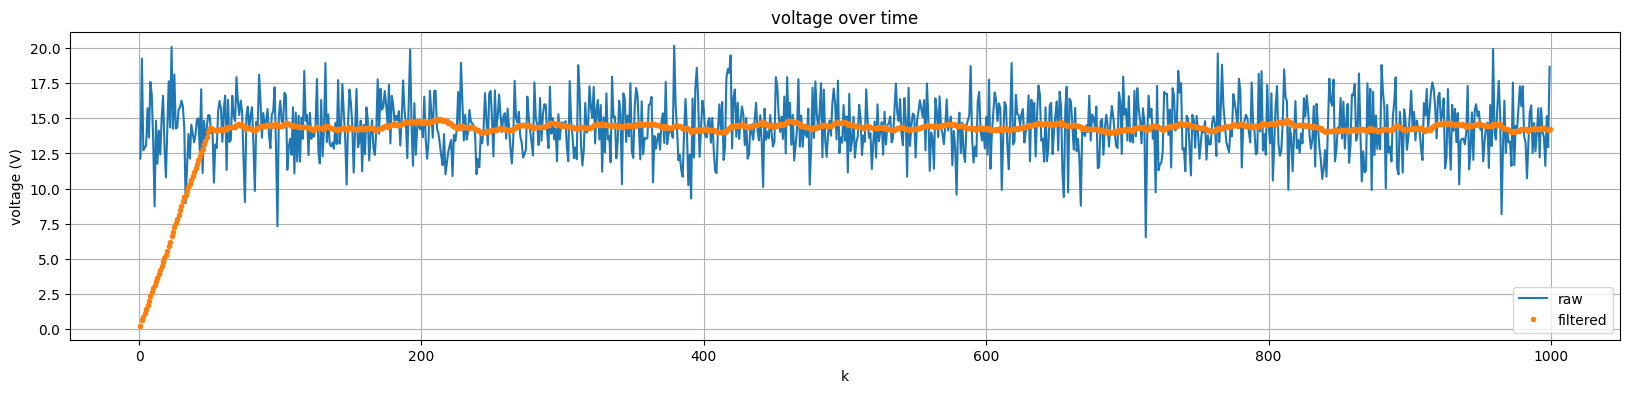

In [19]:
size = 50
buffer = np.zeros(size)
cursor = 0

x_bar_k = 0
readings = []
result = []
for k in range(1, 1000):
    x_k = v.read(1)[0]
    readings.append(x_k)
    
    cursor = k % size
    x_k_n = buffer[cursor]
    buffer[cursor] = x_k
    
    new_x_bar_k = x_bar_k + ((x_k - x_k_n) / size)

    result.append(new_x_bar_k)
    x_bar_k = new_x_bar_k

fig, ax = plt.subplots(figsize=(20, 4), dpi=100)  # 2000x400 px
ax.plot(range(1,1000), readings, marker='', ls='-', color='C0', label='raw')
ax.plot(range(1,1000), result, marker='.', ls='', color='C1', label='filtered')
ax.set(xlabel='k', ylabel='voltage (V)', title='voltage over time')
ax.grid()
ax.legend()
plt.show()

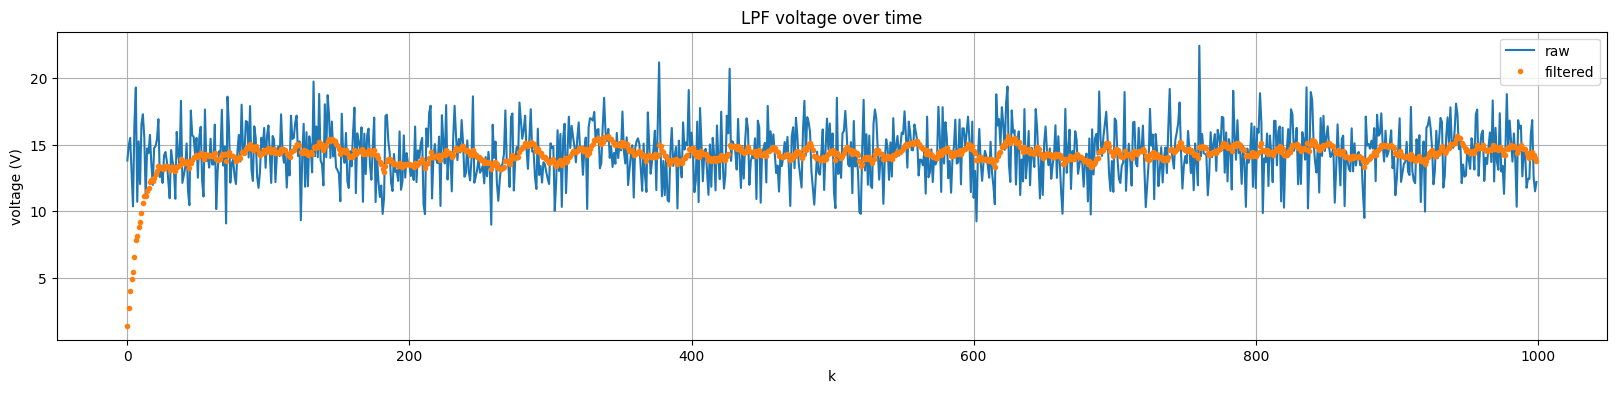

In [20]:

readings = [] 
result = []

x_bar_k = 0
alpha = 0.9
for k in range(0, 1000):
    x_k = v.read(1)[0]
    readings.append(x_k)
    
    new_x_bar_k = (alpha * x_bar_k)  + ((1-alpha)*x_k)

    result.append(new_x_bar_k)
    x_bar_k = new_x_bar_k
    
    
fig, ax = plt.subplots(figsize=(20, 4), dpi=100)  # 2000x400 px
ax.plot(range(0,1000), readings, marker='', ls='-', color='C0', label='raw')
ax.plot(range(0,1000), result, marker='.', ls='', color='C1', label='filtered')
ax.set(xlabel='k', ylabel='voltage (V)', title='LPF voltage over time')
ax.grid()
ax.legend()
plt.show()

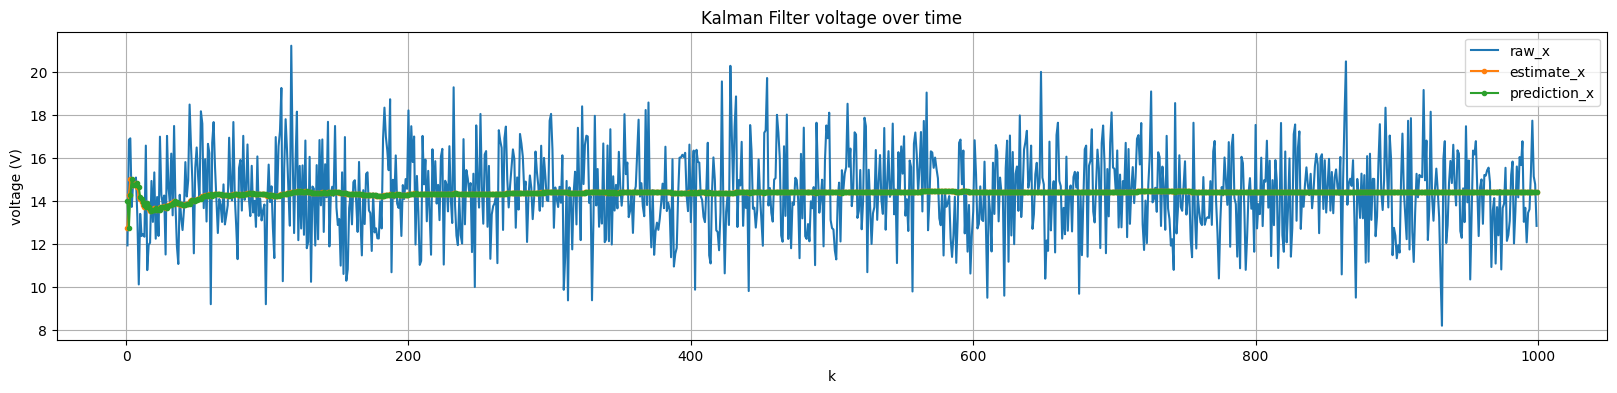

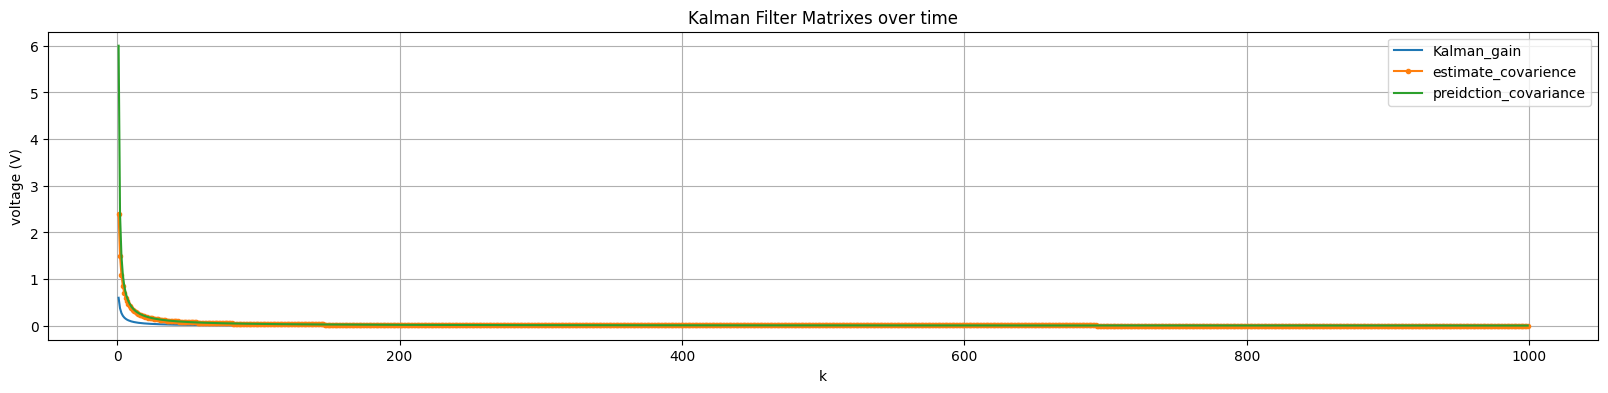

In [21]:
# initial guess at estimate
x = 14
P = 6

# matrixes
A = 1
H = 1
Q = 0
R = 4

raw_x = []
estimate_x = []
estimate_K = []
estimate_P = []

prediction_x = []
prediction_P = []

for k in range(1, 1000):
    x_k = v.read(1)[0]
    raw_x.append(x_k)
    
    # Prediction
    xp = A * x # of estimate
    Pp = A * P * A + Q # of error in estimate
    prediction_x.append(xp)
    prediction_P.append(Pp)
    
    # Compute Kalman Gain
    K = Pp * H / (H * Pp * H + R)
    estimate_K.append(K)

    # compute new estimate, error in estimate
    x = xp + K * (x_k - H * xp)
    P = (1 - K * H) * Pp
    estimate_x.append(x)
    estimate_P.append(P)

    

fig, ax = plt.subplots(figsize=(20, 4), dpi=100)  # 2000x400 px
ax.plot(range(1,1000), raw_x, marker='', ls='-', color='C0', label='raw_x')
ax.plot(range(1,1000), estimate_x, marker='.', ls='-', color='C1', label='estimate_x')
ax.plot(range(1,1000), prediction_x, marker='.', ls='-', color='C2', label='prediction_x')
ax.set(xlabel='k', ylabel='voltage (V)', title='Kalman Filter voltage over time')
ax.grid()
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(20, 4), dpi=100)  # 2000x400 px
ax.plot(range(1,1000), estimate_K, marker='', ls='-', color='C0', label='Kalman_gain')
ax.plot(range(1,1000), estimate_P, marker='.', ls='-', color='C1', label='estimate_covarience')
ax.plot(range(1,1000), prediction_P, marker='', ls='-', color='C2', label='preidction_covariance')
ax.set(xlabel='k', ylabel='voltage (V)', title='Kalman Filter Matrixes over time')
ax.grid()
ax.legend()
plt.show()


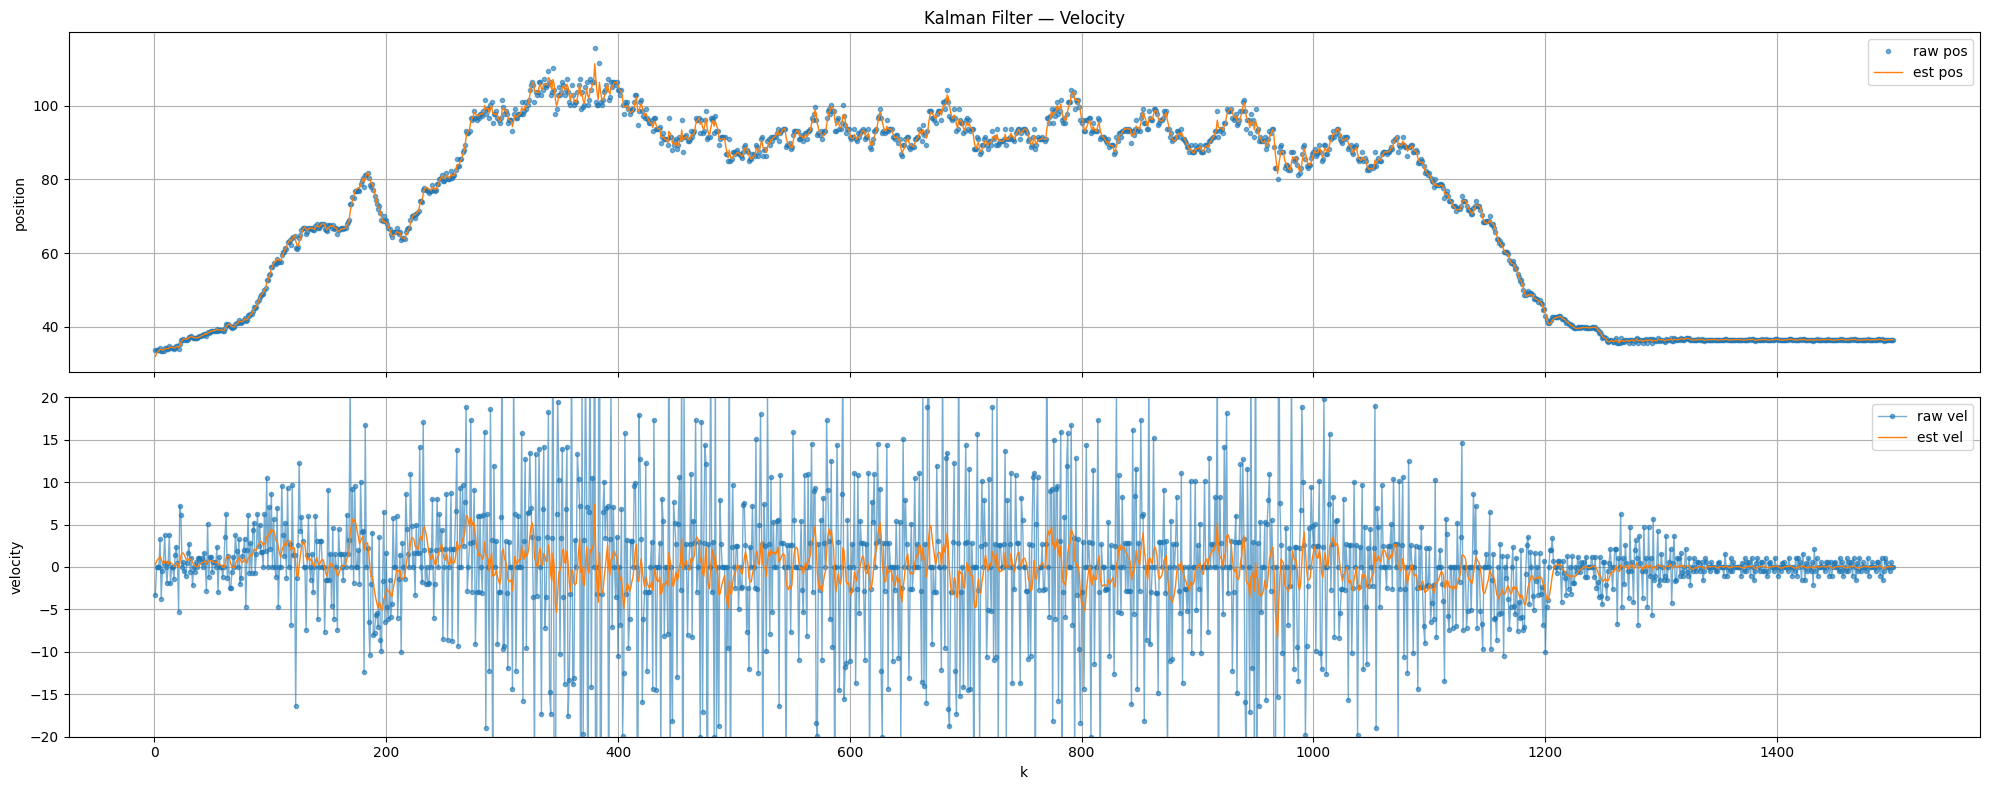

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

data = loadmat("SonarAlt.mat")
raw_x = data["sonarAlt"][0].tolist()


# initial guess at estimate
# state = [position; velocity]
x = np.array([[30.0],
              [0.0]])

P = np.array([[5.0, 0.0],
              [0.0, 5.0]])

# 2x2 matrix
dt = 0.2
A = np.array([[1.0, dt],
              [0.0, 1.0]])

# 1x2 measurement matrix
H = np.array([[1.0, 0.0]])   # shape (1,2)

# process / measurement noise covariances
Q = np.array([[1, 0],
              [0, 3]])       # 2x2

R = np.array([[5.0]])        # 1x1


estimate_x = []
estimate_K = []
estimate_P = []


for k in range(1, len(raw_x)):
    z = np.array([[raw_x[k]]])    # measurement as 1x1 column

    # Prediction
    xp = A @ x                    # 2x1
    Pp = A @ P @ A.T + Q          # 2x2

    # Kalman gain
    S = H @ Pp @ H.T + R          # 1x1
    K = Pp @ H.T @ np.linalg.inv(S)  # 2x1
    estimate_K.append(K.copy())

    # Update
    x = xp + K @ (z - H @ xp)     # 2x1
    P = (np.eye(2) - K @ H) @ Pp  # 2x2
    estimate_x.append(x.copy())
    estimate_P.append(P.copy())

# extract scalar series (position = first state) for plotting
est_pos = [float(xi[0, 0]) for xi in estimate_x]
est_vel = [float(xi[1, 0]) for xi in estimate_x]

 

# raw position / raw velocity (aligned with k=1..N-1)
raw_pos = np.array(raw_x)
raw_pos_plot = raw_pos[1:]
raw_vel = np.diff(raw_pos) / dt  # length = len(raw_x)-1

x_axis = range(1, len(raw_x))  # matches lengths above

# two stacked plots: position (top) and velocity (bottom)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 8), dpi=100, sharex=True)

ax1.plot(x_axis, raw_pos_plot, label='raw pos',   color='C0', marker='.', ls='',  linewidth=1, alpha=0.6)
ax1.plot(x_axis, est_pos,      label='est pos',   color='C1', marker='',  ls='-', linewidth=1, alpha=1.0)
ax1.set(ylabel='position', title='Kalman Filter — Position')
ax1.grid(); ax1.legend()

ax2.plot(x_axis, raw_vel,  label='raw vel',  color='C0', marker='.', ls='-',   linewidth=1, alpha=0.6)
ax2.plot(x_axis, est_vel,  label='est vel',  color='C1', marker='',  ls='-',  linewidth=1, alpha=1.0)
ax1.set(ylabel='position', title='Kalman Filter — Velocity')
ax2.set(xlabel='k', ylabel='velocity', ylim=(-20, 20))
ax2.grid(); ax2.legend()
plt.tight_layout()
plt.show()